<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DATA-PREPARATION" data-toc-modified-id="DATA-PREPARATION-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA PREPARATION</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#PREPARATION-OF-VARIABLES" data-toc-modified-id="PREPARATION-OF-VARIABLES-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>PREPARATION OF VARIABLES</a></span><ul class="toc-item"><li><span><a href="#Creation-of-KPIS-of-the-levers" data-toc-modified-id="Creation-of-KPIS-of-the-levers-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Creation of KPIS of the levers</a></span></li><li><span><a href="#Transformation-of-analysis-variables" data-toc-modified-id="Transformation-of-analysis-variables-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Transformation of analysis variables</a></span></li><li><span><a href="#Creation-of-variables-with-external-data" data-toc-modified-id="Creation-of-variables-with-external-data-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Creation of variables with external data</a></span></li></ul></li><li><span><a href="#WE-SAVE-THE-DATAMART" data-toc-modified-id="WE-SAVE-THE-DATAMART-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>WE SAVE THE DATAMART</a></span></li></ul></li></ul></div>

# DATA PREPARATION

In this phase we are going to create new variables or transform the existing ones in order to give a better answer to our objective.

We will give examples both of how to use internal variables and how to enrich them with external variables.

## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

%config IPCompleter.greedy = True

## Data loading

Create the database connection

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df', con = con)

In [3]:
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,...,f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela


## PREPARATION OF VARIABLES

### Creation of KPIS of the levers

First we are going to create the analysis variables, i.e. those that we had identified as the KPIs that we will use in the levers that influence the business.

We had said that there were 3:

* price per night: we already have this one directly in the price variable, but let's review it to see that we understand it well.
* occupancy: we have availability_365 but we have to transform it.
* price of the property: this we will have to create it with external variables so we leave it for later.

**Let's start with the price.**

The documentation does not clarify if the price is for the entire property, or if in the case of renting a room it is per room.

It is a key data to be able to make the valuation of the potential income of a property.

Let's try to understand it by analyzing the average price by type of rental.

It is important to filter by only one district in order not to include the "zone" effect.

So first we choose a district that has a lot of data.

In [4]:
df.distrito.value_counts()

Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: distrito, dtype: int64

In [5]:
df.loc[df['distrito'] == 'Centro',:].groupby('room_type')['price'].mean()

room_type
Entire home/apt    148.859980
Private room        67.131643
Shared room         60.464286
Name: price, dtype: float64

Conclusion:
    
* renting the apartment has an average price of 148€.
* renting a room has an average price of 60€ or 67€ depending on whether it is a shared or private room
* therefore to calculate the "income" of a property we should multiply the price by the number of rooms when it is a Private room or Shared room.

However, multiplying the price by the total number of rooms can artificially skew a property's earning capacity upwards.

Since if it is rented by rooms, it is not likely to be always at 100%.

Therefore we should weight it by the average percentage of rooms rented.

We do not have that data, but let's assume that we have talked to the business manager and he has told us that it is 70%.

We can create the total price variable by applying apply on a custom function.

In [6]:
def create_total_price(register):
    if (register['beds'] > 1) & ((register['room_type'] == 'Private room') | (register['room_type'] == 'Shared room')):
        output = register['price'] * register['beds'] * 0.7
    else:
        output = register['price']
    return (output)
df['total_price'] = df.apply(create_total_price, axis = 1)

We check

In [7]:
df[['room_type', 'price', 'beds', 'total_price']]

,room_type,price,beds,total_price
0,Private room,60,1.0,60.0
1,Private room,31,1.0,31.0
2,Entire home/apt,50,5.0,50.0
3,Entire home/apt,92,1.0,92.0
4,Private room,26,1.0,26.0
...,...,...,...,...
17705,Private room,29,0.0,29.0
17706,Private room,29,0.0,29.0
17707,Private room,29,0.0,29.0
17708,Private room,29,0.0,29.0


**Now let's go to occupancy**.

The variable we have that allows us to measure this is availability_365.

This variable tells us the number of days a year ahead that the property is NOT occupied.

Therefore we would be interested in transforming it to a more direct measure of occupancy, for example the % of the year that it IS occupied.

We can do this with a direct transformation.

In [8]:
df['availability_365'].head()
#this is the time that the flat is free in the year

0    180
1    364
2    222
3    115
4    349
Name: availability_365, dtype: int64

In [9]:
df['occupancy'] = (((365 - df['availability_365'])/ 365) * 100).astype('int64')
df[['occupancy', 'availability_365']]

,occupancy,availability_365
0,50,180
1,0,364
2,39,222
3,68,115
4,4,349
...,...,...
17705,1,358
17706,1,358
17707,1,358
17708,1,358


### Transformation of analysis variables

Some of the seed questions are aimed at checking how price or occupancy behaves according to other variables such as the number of rooms, the average number of ratings, etc.

We can usually do these analyses better if we discretize the analysis variable.

In our case the candidates for this analysis are: accommodates, bedrooms, beds and number_of_reviews.

In bedrooms a more personalized discretization makes sense. In the others we can do it automatically.

**Discretize bedrooms**

We begin by evaluating the distribution of the data.

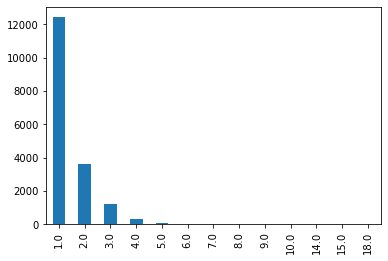

In [10]:
df['bedrooms'].value_counts().plot.bar();

In [11]:
conditions = [df['bedrooms'] == 1, 
              df['bedrooms'] == 2,
              df['bedrooms'] == 3,
              df['bedrooms'] > 3]
outputs = ['1_one', '2_two', '3_three', '4_four']
df['bedrooms_discrete'] = np.select(conditions, outputs, default = -999)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           17710 non-null  int64  
 1   id                              17710 non-null  int64  
 2   name                            17707 non-null  object 
 3   host_id                         17710 non-null  int64  
 4   neighbourhood_group             17710 non-null  object 
 5   neighbourhood                   17710 non-null  object 
 6   latitude                        17710 non-null  float64
 7   longitude                       17710 non-null  float64
 8   room_type                       17710 non-null  object 
 9   price                           17710 non-null  int64  
 10  minimum_nights                  17710 non-null  int64  
 11  calculated_host_listings_count  17710 non-null  int64  
 12  availability_365                

In [13]:
df['bedrooms_discrete'].value_counts()

1_one      12422
2_two       3617
3_three     1228
4_four       443
Name: bedrooms_discrete, dtype: int64

**Discretize accommodates, beds and number_of_reviews**.

Let's use qcut to discretize with percentiles 0.5, 0.8, 1

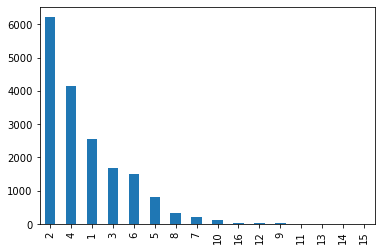

In [14]:
df['accommodates'].value_counts().plot.bar();

In [15]:
df['accommodates_discrete'] = pd.qcut(df['accommodates'], [0,0.5,0.8, 1], labels = ['0 - 2', '3', '4 - 16'])

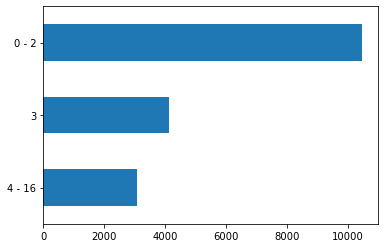

In [16]:
df['accommodates_discrete'].value_counts(ascending = True).plot.barh();

In [17]:
df['beds_discrete'] = pd.qcut(df['beds'], [0,0.5,0.8, 1], labels = ['1', '2', '3 - 23'])

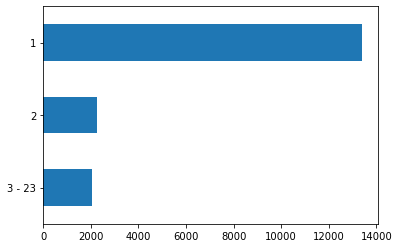

In [18]:
df['beds_discrete'].value_counts(ascending = True).plot.barh();

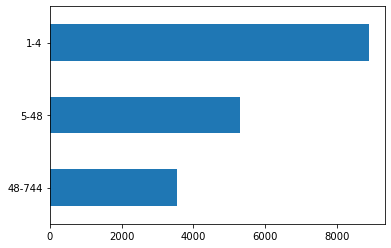

In [19]:
df['number_of_reviews_discrete'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df['number_of_reviews_discrete'].value_counts().sort_index(ascending = False).plot.barh();

### Creation of variables with external data

In this particular case many things could be done with external data.

The first thing, which we have already partially incorporated, is the leverage of the price of the property.

We said that we could estimate it by multiplying the square meters of the property by the price per m2.

We have already got the price_sqm, but the size of the property is not in the data.

What we can do is to establish some criteria based on the number of rooms.

It is not perfect, but it will serve as an approximation.

Estimation of the square meters of the property** **Estimate of the square meters of the property**.

Let's use the following approximation:

* A one-room apartment: m2 = 50
* A two-bedroom apartment: m2 = 70
* A three-room apartment: m2 = 90
* An apartment with four rooms: m2 = 120
* An apartment with five or more rooms: m2 = 150

In [20]:
conditions = [df['bedrooms'] == 1,
              df['bedrooms'] == 2,
              df['bedrooms'] == 3,
              df['bedrooms'] == 4,
              df['bedrooms'] >= 5]
outputs = [50,70,90,120,150]

df['m2'] = np.select(conditions, outputs, default = -999)

In [76]:
df['m2'].value_counts()

50     12422
70      3617
90      1228
120      296
150      147
Name: m2, dtype: int64

Now we can estimate the purchase price of the property.

We remember that the price we get is reduced by 30% for bargaining power.

In [21]:
df['purchase_price'] = df['m2'] * df ['precio_m2'] * 0.7

In [22]:
df[['bedrooms', 'm2', 'distrito', 'precio_m2', 'purchase_price' ]]

,bedrooms,m2,distrito,precio_m2,purchase_price
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
...,...,...,...,...,...
17705,1.0,50,Centro,4827,168945.0
17706,1.0,50,Centro,4827,168945.0
17707,1.0,50,Centro,4827,168945.0
17708,1.0,50,Salamanca,6114,213990.0


Taking into account that in tourism the location is very important, we are going to calculate the distance of the different properties to one of the most important touristic points of Madrid, the Puerta del Sol.

This analysis could be done with more points of interest, taking into account that we have the x,y coordinates, but in this project we will only take into account the distance to the Puerta del Sol.

To do this we search in Google its longitude and latitude: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitude: 40.4167278
Longitude: -3.7033387

**Calculation of the distance from each property to the Puerta del Sol**.

Given the curvature of the earth the distance between two points from their latitude and longitude is calculated with a formula called Haversine distance.

A Google search gives us an already built function to calculate it that we can adapt: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [29]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    
    #This function returns the distance taking into account the curvature of the earth

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c


We create the variable

In [31]:
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda register: haversine(lat1,lon1, register['latitude'], register['longitude']), axis = 1)

We checked by reviewing the average distance by districts.

In [34]:
df.groupby('distrito')['pdi_sol'].mean().sort_values(Comprobamos revisando la distancia media por distritos.)

distrito
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: pdi_sol, dtype: float64

## WE SAVE THE DATAMART

We are going to save this version as df_prepared

In [35]:
df.to_sql('df_ready', con = con, if_exists = 'replace')